In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

import pandas as pd
import numpy as np
import re

import nltk
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS

np.random.seed(2018)
from pprint import pprint

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv(r"C:\Users\Tanmay\Downloads\Reddit_Data.csv")
data.rename(columns = {'clean_comment':'tweet'}, inplace = True)
data = data.sample(frac = 1)
data = data.reset_index()
data = data[['tweet', 'category']]
data = data.loc[data['category'].isin([1, -1])]
data=data.replace(-1,0)
data.head()

,tweet,category
0,wrong that day not brahmin because you are bra...,0
1,clear evidence that pakistani was involved th...,1
2,have met him last month great guy,1
3,team full ppr pick crowell nyg lewis @ nyj sa...,1
4,wow just wow don even have any words say this,1


In [4]:
#Preprocessing
#Removing null values
data=data.dropna()
data = data.reset_index(drop=True)
data

,tweet,category
0,wrong that day not brahmin because you are bra...,0
1,clear evidence that pakistani was involved th...,1
2,have met him last month great guy,1
3,team full ppr pick crowell nyg lewis @ nyj sa...,1
4,wow just wow don even have any words say this,1
...,...,...
24102,individual muslims are not bad islamic ideology,1
24103,strengths kohli weaknesses kohli love kohli l...,1
24104,isn quite fast,1
24105,demonitization fails incorrect not question f...,0


In [5]:
#Lower casing
data['pre_process'] = data['tweet'].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))
data.head()

,tweet,category,pre_process
0,wrong that day not brahmin because you are bra...,0,wrong that day not brahmin because you are bra...
1,clear evidence that pakistani was involved th...,1,clear evidence that pakistani was involved the...
2,have met him last month great guy,1,have met him last month great guy
3,team full ppr pick crowell nyg lewis @ nyj sa...,1,team full ppr pick crowell nyg lewis @ nyj san...
4,wow just wow don even have any words say this,1,wow just wow don even have any words say this


In [6]:
#Remove the HTML tags, URLs and usernames from the reviews.
data['pre_process']=data['pre_process'].apply(lambda x: BeautifulSoup(x).get_text())
data['pre_process']=data['pre_process'].apply(lambda x: re.sub(r'http\S+', '', x))
data['pre_process']=data['pre_process'].apply(lambda x: re.sub(r'@\S+', '', x))
data.head()

C:\Users\shahv\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,tweet,category,pre_process
0,wrong that day not brahmin because you are bra...,0,wrong that day not brahmin because you are bra...
1,clear evidence that pakistani was involved th...,1,clear evidence that pakistani was involved the...
2,have met him last month great guy,1,have met him last month great guy
3,team full ppr pick crowell nyg lewis @ nyj sa...,1,team full ppr pick crowell nyg lewis @ nyj san...
4,wow just wow don even have any words say this,1,wow just wow don even have any words say this


In [7]:
#Removing word contractions
def contractions(s):
    s = re.sub(r"won't", "will not",s)
    s = re.sub(r"would't", "would not",s)
    s = re.sub(r"could't", "could not",s)
    s = re.sub(r"\'d", " would",s)
    s = re.sub(r"can\'t", "can not",s)
    s = re.sub(r"n\'t", " not", s)
    s= re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    return s
data['pre_process']=data['pre_process'].apply(lambda x:contractions(x))
data.head()

,tweet,category,pre_process
0,wrong that day not brahmin because you are bra...,0,wrong that day not brahmin because you are bra...
1,clear evidence that pakistani was involved th...,1,clear evidence that pakistani was involved the...
2,have met him last month great guy,1,have met him last month great guy
3,team full ppr pick crowell nyg lewis @ nyj sa...,1,team full ppr pick crowell nyg lewis @ nyj san...
4,wow just wow don even have any words say this,1,wow just wow don even have any words say this


In [8]:
#Removing non-alpha characters
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))
data.head()

,tweet,category,pre_process
0,wrong that day not brahmin because you are bra...,0,wrong that day not brahmin because you are bra...
1,clear evidence that pakistani was involved th...,1,clear evidence that pakistani was involved the...
2,have met him last month great guy,1,have met him last month great guy
3,team full ppr pick crowell nyg lewis @ nyj sa...,1,team full ppr pick crowell nyg lewis nyj sanu...
4,wow just wow don even have any words say this,1,wow just wow don even have any words say this


In [9]:
#Removing extra spaces
data['pre_process']=data['pre_process'].apply(lambda x: re.sub(' +', ' ', x))
data.head()

,tweet,category,pre_process
0,wrong that day not brahmin because you are bra...,0,wrong that day not brahmin because you are bra...
1,clear evidence that pakistani was involved th...,1,clear evidence that pakistani was involved the...
2,have met him last month great guy,1,have met him last month great guy
3,team full ppr pick crowell nyg lewis @ nyj sa...,1,team full ppr pick crowell nyg lewis nyj sanu ari
4,wow just wow don even have any words say this,1,wow just wow don even have any words say this


In [10]:
#Removing stopwords
stop = stopwords.words('english')
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
data.head()

,tweet,category,pre_process
0,wrong that day not brahmin because you are bra...,0,wrong day brahmin brahmin brahmin brahmin brah...
1,clear evidence that pakistani was involved th...,1,clear evidence pakistani involved aerial battl...
2,have met him last month great guy,1,met last month great guy
3,team full ppr pick crowell nyg lewis @ nyj sa...,1,team full ppr pick crowell nyg lewis nyj sanu ari
4,wow just wow don even have any words say this,1,wow wow even words say


In [11]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
data['pre_process']=data['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
data.head()

,tweet,category,pre_process
0,wrong that day not brahmin because you are bra...,0,wrong day brahmin brahmin brahmin brahmin brah...
1,clear evidence that pakistani was involved th...,1,clear evidence pakistani involved aerial battl...
2,have met him last month great guy,1,met last month great guy
3,team full ppr pick crowell nyg lewis @ nyj sa...,1,team full ppr pick crowell nyg lewis nyj sanu ari
4,wow just wow don even have any words say this,1,wow wow even word say


In [12]:
#Descriptive Statistics
text = " ".join(review for review in data.pre_process)
split = text.split()

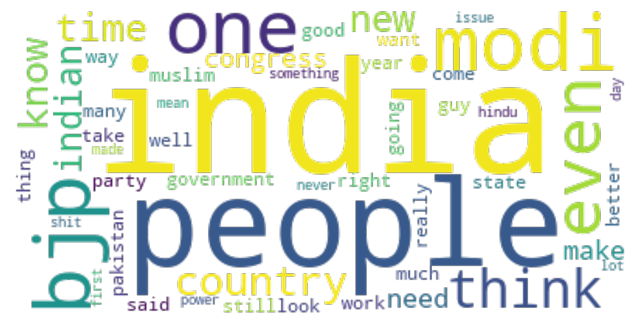

In [13]:
stopwords =  set(STOPWORDS)
stopwords.update(['movie', 'film', 'show', 'see', 'watch', 'seen', 'seem', 'say'])

#Generate a wordcloud image
wordcloud = WordCloud(mode = 'RGBA', max_font_size = 100, stopwords = stopwords, max_words = 50, 
                      background_color = None).generate(text)

#Display the generated image the matplotlib way
plt.imshow(wordcloud, interpolation = 'mitchell')
plt.axis('off')
plt.show()

In [14]:
#Frequency Distribution Table
freq_dist = nltk.FreqDist(split)
freq_dist = pd.DataFrame(freq_dist.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
freq_dist.head()

,word,frequency
31,people,5186
348,india,4711
214,like,4497
211,bjp,4414
197,modi,4163


<AxesSubplot:xlabel='frequency', ylabel='word'>

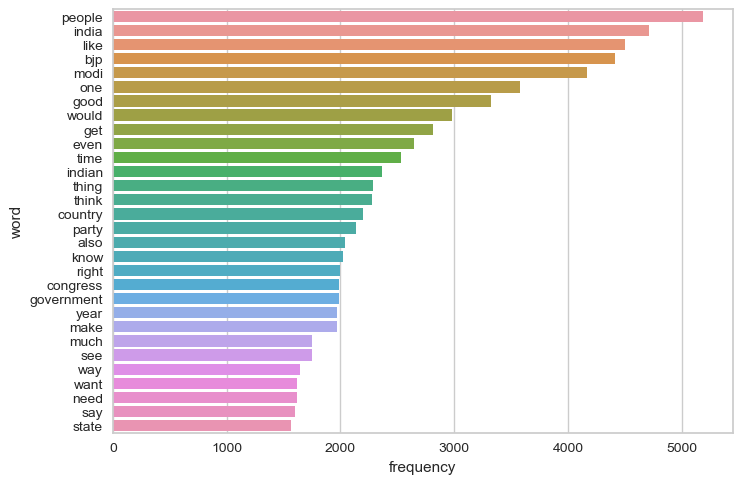

In [15]:
#Frequency Distribution Barplot
sns.barplot(x='frequency',y='word',data=freq_dist.head(30))

In [16]:
# WORD-COUNT
data['word_count'] = data['tweet'].apply(lambda x: len(str(x).split()))
print(data[data['category']==1]['word_count'].mean()) #Positive tweets
print(data[data['category']==0]['word_count'].mean()) #Negative tweets

42.778016424510426
34.79340340703153


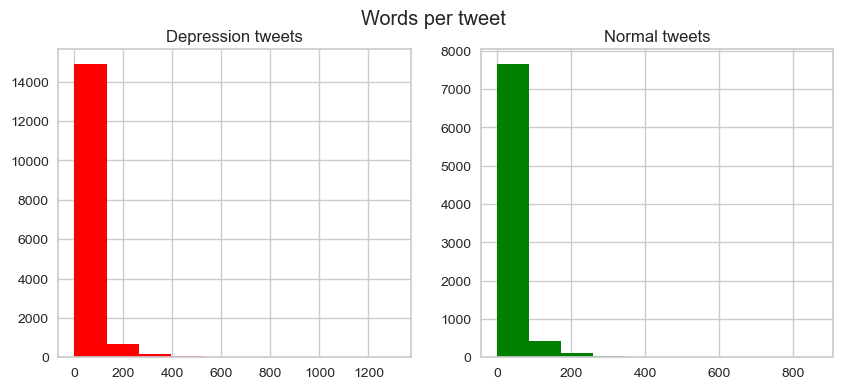

In [17]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=data[data['category']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Depression tweets')
train_words=data[data['category']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Normal tweets')
fig.suptitle('Words per tweet')
plt.show()

In [18]:
#Word Embedding (TF-IDF)
#Splitting into train and test datasets
x_train,x_test,y_train, y_test = train_test_split(data['pre_process'], data['category'], test_size=0.25, random_state=30)
print("Train: ",x_train.shape,x_train.shape,"Test: ",(x_test.shape,y_test.shape))

Train:  (18080,) (18080,) Test:  ((6027,), (6027,))


In [19]:
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(x_train)
tf_x_test = vectorizer.transform(x_test)
tf_x_train

<18080x34317 sparse matrix of type '<class 'numpy.float64'>'
	with 396949 stored elements in Compressed Sparse Row format>

In [20]:
#Classification
#Fitting the classification model using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')

lr_tfidf.fit(tf_x_train, y_train)  

#Predict y value for test dataset
y_predict = lr_tfidf.predict(tf_x_test)

y_prob = lr_tfidf.predict_proba(tf_x_test)[:,1]

print(classification_report(y_test,y_predict))

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      2094
           1       0.87      0.93      0.90      3933

    accuracy                           0.86      6027
   macro avg       0.86      0.84      0.85      6027
weighted avg       0.86      0.86      0.86      6027

Confusion Matrix: [[1569  525]
 [ 290 3643]]
AUC: 0.9337166400629843


In [21]:
#Fitting the classification model using Naive Bayes(tf-idf)

nb_tfidf = MultinomialNB()

nb_tfidf.fit(tf_x_train, y_train)  

#Predict y value for test dataset

y_predict = nb_tfidf.predict(tf_x_test)

y_prob = nb_tfidf.predict_proba(tf_x_test)[:,1]

print(classification_report(y_test,y_predict))

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.97      0.11      0.19      2094
           1       0.68      1.00      0.81      3933

    accuracy                           0.69      6027
   macro avg       0.82      0.55      0.50      6027
weighted avg       0.78      0.69      0.59      6027

Confusion Matrix: [[ 227 1867]
 [   8 3925]]
AUC: 0.8487672332000357


In [22]:
#Hence, logistic regression gives an accuracy score of 0.99. Thus, it is a better fit.

In [23]:
#Cluster Analysis
#Reading the reviews column into an array
documents = data.iloc[:,-2].tolist()
documents[:5]

['wrong day brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin brahmin',
 'clear evidence pakistani involved aerial battle naushera aim fired',
 'met last month great guy',
 'team full ppr pick crowell nyg lewis nyj sanu ari',
 'wow wow even word say']

In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

In [25]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

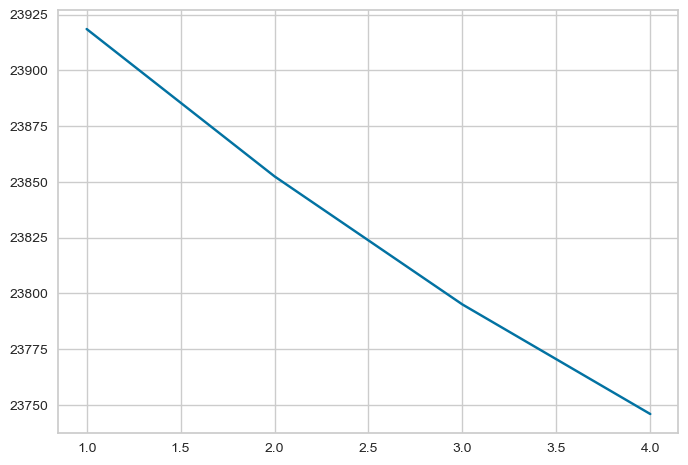

In [26]:
wcss=[]
for i in range(1,5):
    clustering = KMeans(n_clusters = i,init='k-means++',random_state=42)
    clustering.fit(X)
    wcss.append(clustering.inertia_)
ks = [1,2,3,4]
sns.lineplot(x = ks,y =wcss);

In [27]:
true_k = 2
model = KMeans(n_clusters = true_k, init='k-means++',max_iter = 100 , n_init = 1)
model.fit(X)

KMeans(max_iter=100, n_clusters=2, n_init=1)

In [28]:
print("Top terms per cluster :")
order_centroids = model.cluster_centers_.argsort()[:,::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i,:5]:
        print(' %s' % terms[ind]);
    print

Top terms per cluster :
Cluster 0:
 bjp
 congress
 party
 vote
 modi
Cluster 1:
 india
 people
 like
 modi
 good


In [29]:
#Topic Modelling
df=pd.DataFrame()
df['split'] = data['pre_process'].apply(lambda x: x.split())
df

,split
0,"[wrong, day, brahmin, brahmin, brahmin, brahmi..."
1,"[clear, evidence, pakistani, involved, aerial,..."
2,"[met, last, month, great, guy]"
3,"[team, full, ppr, pick, crowell, nyg, lewis, n..."
4,"[wow, wow, even, word, say]"
...,...
24102,"[individual, muslim, bad, islamic, ideology]"
24103,"[strength, kohli, weakness, kohli, love, kohli..."
24104,"[quite, fast]"
24105,"[demonitization, fails, incorrect, question, f..."


In [30]:
#Word Embedding on split text
#Creating a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set..

#Creating a vocabulary
dictionary = gensim.corpora.Dictionary(df['split'])

In [31]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 brahmin
1 day
2 wrong
3 aerial
4 aim
5 battle
6 clear
7 evidence
8 fired
9 involved
10 naushera


In [32]:
#Doc2BOW
#Filtering out tokens that appear in less than 15 documents or more than 0.5 documents. After the above two steps, keeping only the first 100000 most frequent tokens.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)

In [33]:
#For each document we create a dictionary reporting how many words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier.
bow_corpus = [dictionary.doc2bow(doc) for doc in df['split']]
bow_corpus[4310]

[(12, 1),
 (18, 1),
 (19, 1),
 (118, 1),
 (232, 1),
 (348, 1),
 (599, 1),
 (712, 1),
 (4109, 1)]

In [34]:
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))

Word 12 ("last") appears 1 time.
Word 18 ("ppr") appears 1 time.
Word 19 ("team") appears 1 time.
Word 118 ("first") appears 1 time.
Word 232 ("time") appears 1 time.
Word 348 ("got") appears 1 time.
Word 599 ("week") appears 1 time.
Word 712 ("long") appears 1 time.
Word 4109 ("sea") appears 1 time.


In [35]:
#Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.9991497516684781), (1, 0.02640222181363197), (2, 0.031665382109207975)]


In [36]:
#LDA using BOW
#Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [37]:
#For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"good" + 0.011*"well" + 0.010*"people" + 0.008*"even" + 0.008*"muslim" + 0.008*"result" + 0.006*"think" + 0.006*"work" + 0.005*"time" + 0.005*"hindu"
Topic: 1 
Words: 0.017*"india" + 0.013*"people" + 0.011*"like" + 0.010*"muslim" + 0.009*"hindu" + 0.008*"country" + 0.008*"state" + 0.006*"indian" + 0.006*"bjp" + 0.006*"pakistan"
Topic: 2 
Words: 0.035*"bjp" + 0.020*"congress" + 0.018*"party" + 0.011*"election" + 0.010*"government" + 0.009*"modi" + 0.008*"people" + 0.008*"like" + 0.007*"vote" + 0.007*"would"
Topic: 3 
Words: 0.016*"people" + 0.010*"know" + 0.010*"one" + 0.008*"right" + 0.008*"make" + 0.008*"country" + 0.007*"like" + 0.006*"want" + 0.006*"think" + 0.006*"even"
Topic: 4 
Words: 0.028*"best" + 0.021*"movie" + 0.019*"way" + 0.017*"get" + 0.017*"overall" + 0.016*"fuck" + 0.016*"vote" + 0.012*"good" + 0.009*"che" + 0.009*"like"
Topic: 5 
Words: 0.035*"good" + 0.019*"modi" + 0.011*"like" + 0.010*"one" + 0.009*"time" + 0.008*"people" + 0.008*"really" + 0.0

In [38]:
#LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [39]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"bjp" + 0.005*"people" + 0.004*"modi" + 0.004*"party" + 0.004*"india" + 0.004*"like" + 0.003*"nice" + 0.003*"congress" + 0.003*"would" + 0.003*"get"
Topic: 1 Word: 0.007*"shit" + 0.004*"like" + 0.004*"modi" + 0.004*"india" + 0.004*"people" + 0.004*"good" + 0.004*"get" + 0.004*"medium" + 0.003*"guy" + 0.003*"bjp"
Topic: 2 Word: 0.005*"bjp" + 0.005*"modi" + 0.005*"people" + 0.004*"india" + 0.004*"like" + 0.004*"muslim" + 0.004*"real" + 0.003*"would" + 0.003*"hindu" + 0.003*"think"
Topic: 3 Word: 0.007*"best" + 0.006*"fucking" + 0.006*"true" + 0.005*"right" + 0.005*"modi" + 0.005*"love" + 0.004*"better" + 0.004*"india" + 0.004*"one" + 0.004*"people"
Topic: 4 Word: 0.005*"good" + 0.005*"love" + 0.005*"bjp" + 0.005*"modi" + 0.004*"people" + 0.004*"like" + 0.004*"india" + 0.004*"time" + 0.003*"would" + 0.003*"know"
Topic: 5 Word: 0.010*"good" + 0.007*"lol" + 0.004*"one" + 0.004*"people" + 0.004*"like" + 0.004*"much" + 0.004*"post" + 0.004*"thank" + 0.004*"work" + 0.003*"

In [40]:
#Performance evaluation by classifying sample document using LDA Bag of Words model
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6142942905426025	 
Topic: 0.016*"people" + 0.013*"team" + 0.011*"free" + 0.008*"encyclopedia" + 0.007*"get" + 0.007*"like" + 0.007*"much" + 0.007*"day" + 0.006*"one" + 0.006*"reached"

Score: 0.3056735098361969	 
Topic: 0.035*"bjp" + 0.020*"congress" + 0.018*"party" + 0.011*"election" + 0.010*"government" + 0.009*"modi" + 0.008*"people" + 0.008*"like" + 0.007*"vote" + 0.007*"would"

Score: 0.010004343464970589	 
Topic: 0.035*"good" + 0.019*"modi" + 0.011*"like" + 0.010*"one" + 0.009*"time" + 0.008*"people" + 0.008*"really" + 0.007*"said" + 0.007*"look" + 0.005*"point"

Score: 0.010004203766584396	 
Topic: 0.013*"good" + 0.011*"well" + 0.010*"people" + 0.008*"even" + 0.008*"muslim" + 0.008*"result" + 0.006*"think" + 0.006*"work" + 0.005*"time" + 0.005*"hindu"

Score: 0.010004119016230106	 
Topic: 0.016*"people" + 0.010*"know" + 0.010*"one" + 0.008*"right" + 0.008*"make" + 0.008*"country" + 0.007*"like" + 0.006*"want" + 0.006*"think" + 0.006*"even"

Score: 0.010004086419939995	

In [41]:
#Performance evaluation by classifying sample document using LDA TF-IDF model.
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.9099661707878113	 
Topic: 0.011*"fuck" + 0.005*"bjp" + 0.004*"look" + 0.004*"like" + 0.004*"team" + 0.004*"modi" + 0.004*"people" + 0.004*"congress" + 0.003*"free" + 0.003*"full"

Score: 0.010006798431277275	 
Topic: 0.005*"good" + 0.005*"love" + 0.005*"bjp" + 0.005*"modi" + 0.004*"people" + 0.004*"like" + 0.004*"india" + 0.004*"time" + 0.003*"would" + 0.003*"know"

Score: 0.010003997012972832	 
Topic: 0.008*"thanks" + 0.004*"one" + 0.004*"modi" + 0.003*"like" + 0.003*"good" + 0.003*"india" + 0.003*"bjp" + 0.003*"people" + 0.003*"new" + 0.003*"get"

Score: 0.010003600269556046	 
Topic: 0.006*"wtf" + 0.005*"bjp" + 0.005*"modi" + 0.005*"india" + 0.004*"wow" + 0.004*"great" + 0.004*"like" + 0.004*"win" + 0.004*"one" + 0.004*"people"

Score: 0.010003447532653809	 
Topic: 0.010*"good" + 0.007*"lol" + 0.004*"one" + 0.004*"people" + 0.004*"like" + 0.004*"much" + 0.004*"post" + 0.004*"thank" + 0.004*"work" + 0.003*"great"

Score: 0.010003344155848026	 
Topic: 0.005*"really" + 0.004*"